Calculate daily mean SSH at Neah Bay

In [1]:
import arrow
import datetime
import matplotlib.pyplot as plt
import os
import pandas as pd
import xarray as xr

%matplotlib inline

In [2]:
basedir = '/results/forcing/sshNeahBay/obs'
xb, yb = 50, 0 

In [12]:
xr.open_dataset('/results/forcing/sshNeahBay/obs/ssh_y2020m12d02.nc', decode_cf=False)

<xarray.Dataset>
Dimensions:       (time_counter: 24, xbT: 100, yb: 1)
Coordinates:
  * time_counter  (time_counter) float32 1.0 2.0 3.0 4.0 ... 21.0 22.0 23.0 24.0
Dimensions without coordinates: xbT, yb
Data variables:
    nav_lat       (yb, xbT) float32 ...
    nav_lon       (yb, xbT) float32 ...
    sossheig      (time_counter, yb, xbT) float32 ...
    vobtcrtx      (time_counter, yb, xbT) float32 ...
    vobtcrty      (time_counter, yb, xbT) float32 ...
    nbidta        (yb, xbT) int32 ...
    nbjdta        (yb, xbT) int32 ...
    nbrdta        (yb, xbT) int32 ...
Attributes:
    Conventions:  CF-1.6
    title:        Neah Bay SSH hourly values
    institution:  Dept of Earth, Ocean & Atmospheric Sciences, University of ...
    source:       /results/forcing/sshNeahBay/txt/sshNB_2020-12-03_19.txt
    references:   https://github.com/SalishSeaCast/SalishSeaNowcast/blob/mast...
    history:      [2020-12-03 11:40:03] Created netCDF4 zlib=True dataset.
    comment:      Observation from Neah Bay storm surge website generated by ...

In [13]:
year = 2018
start = datetime.datetime(year, 1, 1)
endtime = datetime.datetime(year, 12, 31)
timerange = arrow.Arrow.range('day', start, endtime)
for i, day in enumerate(timerange):
    ymd = day.format('YYYYMMDD')
    filename = f'ssh_y{day.year}m{day.month:02d}d{day.day:02d}.nc'
    fullfile = os.path.join(basedir, filename)
    neah = xr.open_dataset(fullfile, decode_cf=False)
    ssh = neah['sossheig'].isel(yb=yb, xbT=xb).mean()
    neah.close()
    if i == 0:
        ssh_year = ssh.copy(deep=True)
        ssh.close()
    else:
        ssh_year = xr.concat([ssh_year, ssh], dim='time_counter')
        ssh.close()
    if i % 100 == 0:
        print (i)

0
100
200
300


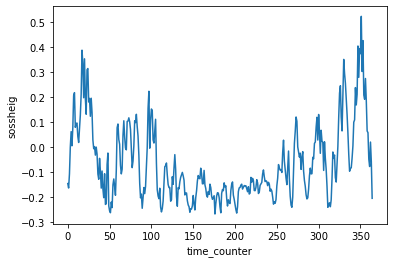

In [14]:
ssh_year.plot();

In [15]:
ssh_year.to_netcdf(f'ssh_{year}.nc')

## Now Low Pass Filter the Velocities ##

In [20]:
ssh2015 = xr.open_dataset('ssh_2015.nc')
ssh2016 = xr.open_dataset('ssh_2016.nc')
ssh2017 = xr.open_dataset('ssh_2017.nc')
ssh2018 = xr.open_dataset('ssh_2018.nc')
ssh = xr.concat([ssh2015, ssh2016, ssh2017, ssh2018], dim='time_counter', coords='minimal')

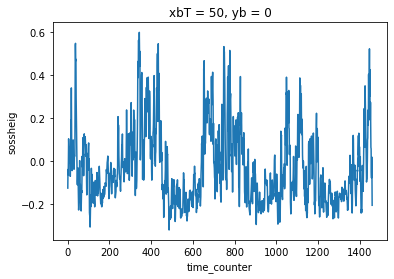

In [31]:
ssh.sossheig.plot();

In [37]:
ssh_pd = ssh.to_dataframe()
ssh_pd = ssh_pd.drop('xbT', 1)
ssh_pd = ssh_pd.drop('yb', 1)
ssh_pd.to_csv('day_avg_ssh.csv')
ssh_pd

,sossheig
time_counter,
0,-0.125347
1,-0.038566
2,-0.063083
3,0.001806
4,0.104299
...,...
1456,-0.048620
1457,-0.078037
1458,0.019949


<AxesSubplot:xlabel='time_counter'>

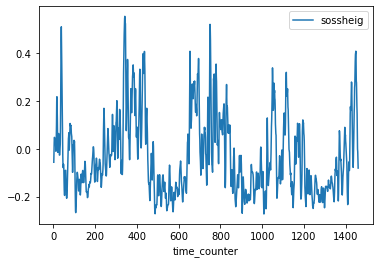

In [38]:
low_pass_ssh = ssh_pd.rolling(4, center=True).mean()
low_pass_ssh.to_csv('low_pass_ssh.csv')
low_pass_ssh.plot()

In [39]:
ssh2015.close()
ssh2016.close()
ssh2017.close()
ssh2018.close()